### Fraud Detection Model Training

#### Contents

- Importing the libaries
- Loading the data
- Data Inspection and Cleaning
- Outlier detection and treatment 
- Feature Engineering
- Feature Selection
- Data Splitting
- Model Training
- Model Evaluation

#### 1.) Importing the Libaries

In [1]:


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
from datetime import timedelta

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


#### 2.) Loading The Datasets

In [2]:
loan_applications_df = pd.read_csv(r'C:\Users\Zuhayr Adams\Projects\Fraud Detection\notebook\data\loan_applications.csv')
loan_applications_df['application_date'] = pd.to_datetime(loan_applications_df['application_date'])

transactions_df = pd.read_csv(r'C:\Users\Zuhayr Adams\Projects\Fraud Detection\notebook\data\transactions.csv')
transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'])

#### 3.) Data Inspection and Cleaning

In [3]:
loan_applications_df.info()
loan_applications_df['fraud_type'].fillna('Not Fraudulent')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   application_id             50000 non-null  object        
 1   customer_id                50000 non-null  object        
 2   application_date           50000 non-null  datetime64[ns]
 3   loan_type                  50000 non-null  object        
 4   loan_amount_requested      50000 non-null  float64       
 5   loan_tenure_months         50000 non-null  int64         
 6   interest_rate_offered      50000 non-null  float64       
 7   purpose_of_loan            50000 non-null  object        
 8   employment_status          50000 non-null  object        
 9   monthly_income             50000 non-null  float64       
 10  cibil_score                50000 non-null  int64         
 11  existing_emis_monthly      50000 non-null  float64       
 12  debt

0        Not Fraudulent
1        Not Fraudulent
2        Not Fraudulent
3        Not Fraudulent
4        Not Fraudulent
              ...      
49995    Not Fraudulent
49996    Not Fraudulent
49997    Not Fraudulent
49998    Not Fraudulent
49999    Not Fraudulent
Name: fraud_type, Length: 50000, dtype: object

In [4]:
loan_applications_df.head()

,application_id,customer_id,application_date,loan_type,loan_amount_requested,loan_tenure_months,interest_rate_offered,purpose_of_loan,employment_status,monthly_income,...,existing_emis_monthly,debt_to_income_ratio,property_ownership_status,residential_address,applicant_age,gender,number_of_dependents,loan_status,fraud_flag,fraud_type
0,c8bf0bea-70e6-4870-9125-41b8210c527f,CUST109427,2023-04-09,Business Loan,604000.0,12,11.66,Medical Emergency,Retired,34700.0,...,1100.0,3.17,Rented,"94/31, Sehgal Zila, Vadodara-380521, Anantapur...",28,Female,3,Approved,0,NaN
1,91224cec-3544-4bc7-ac15-a9792da54c02,CUST106146,2023-09-23,Car Loan,100000.0,240,13.62,Education,Unemployed,51600.0,...,0.0,0.00,Owned,"H.No. 00, Sheth Chowk, Ichalkaranji 006728, Im...",44,Other,3,Approved,0,NaN
2,4efcd02d-4a03-4ab7-9bd1-0ff430493d0c,CUST100674,2023-05-22,Education Loan,431000.0,60,11.40,Medical Emergency,Self-Employed,14800.0,...,4600.0,31.08,Rented,"H.No. 81, Dutta Path, Kozhikode-340301, Tadepa...",56,Other,4,Approved,0,NaN
3,a61337d4-ba04-4a68-b492-2cb8266e6ed7,CUST106466,2024-07-09,Car Loan,324000.0,120,10.36,Debt Consolidation,Self-Employed,28800.0,...,4000.0,13.89,Rented,"H.No. 022, Rege Road, Tiruvottiyur-927857, Aur...",27,Other,4,Declined,0,NaN
4,a8d1639e-170b-41b2-826a-55c7dae38d16,CUST112319,2023-11-20,Personal Loan,100000.0,36,14.14,Business Expansion,Salaried,43900.0,...,1100.0,2.51,Rented,"85/24, Bali Zila, Sambalpur 922071, Tumkur, Ke...",50,Other,0,Declined,0,NaN


In [5]:
transactions_df.head()

,transaction_id,customer_id,transaction_date,transaction_type,transaction_amount,merchant_category,merchant_name,transaction_location,account_balance_after_transaction,is_international_transaction,device_used,ip_address,transaction_status,transaction_source_destination,transaction_notes,fraud_flag
0,2d7ddfd4-1112-4354-a2dd-fad94b45a850,CUST102188,2022-01-04 11:27:00,Bill Payment,2100.0,Dining,"Rattan, Khanna and Magar","Srikakulam, Himachal Pradesh",8211.0,0,Web,31.102.21.141,Success,BCHG80012468703731,Payment for Dining,0
1,ba998721-a612-4e0a-8354-46d001e9c39c,CUST107144,2022-01-03 23:52:00,UPI,1400.0,Travel,Chauhan LLC,"Giridih, Manipur",12858.0,0,Web,176.48.222.166,Success,CJPZ11841095072972,Payment for Travel,0
2,0b4ad8e2-40ac-49c9-b59a-c9efaaccc7a6,CUST102126,2022-01-15 06:54:00,Debit Card,1000.0,Entertainment,Halder-Sarma,"Avadi, Kerala",19268.0,0,ATM,181.62.105.161,Success,TLCG50761416960179,Payment for Entertainment,0
3,c4fce988-34c5-48db-8686-bfad0b3bc0b5,CUST109887,2022-01-08 07:57:00,Credit Card,10500.0,Utilities,"Anand, Khare and Balakrishnan","Navi Mumbai, Maharashtra",29585.0,0,ATM,121.157.246.80,Success,PRZJ55096553432036,Payment for Utilities,0
4,f9b8ca30-00e5-4322-8cff-eac0554cf2da,CUST108620,2022-01-02 10:43:00,Loan Disbursement,8100.0,Electronics,Zacharia and Sons,"Visakhapatnam, Gujarat",0.0,0,ATM,129.96.5.57,Success,NBAI29021393288369,Payment for Electronics,0


In [6]:
loan_applications_df.describe()

,application_date,loan_amount_requested,loan_tenure_months,interest_rate_offered,monthly_income,cibil_score,existing_emis_monthly,debt_to_income_ratio,applicant_age,number_of_dependents,fraud_flag
count,50000,5.000000e+04,50000.0000,50000.000000,50000.000000,50000.000000,50000.0000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2023-12-04 17:29:54.240000,5.139130e+05,121.3884,10.528547,50844.940000,699.149760,3066.3620,8.573188,43.060880,2.012280,0.020520
min,2022-06-05 00:00:00,1.000000e+05,12.0000,7.000000,10000.000000,476.000000,0.0000,0.000000,21.000000,0.000000,0.000000
25%,2023-03-04 00:00:00,3.000000e+05,24.0000,9.150000,33600.000000,665.000000,1700.0000,3.090000,32.000000,1.000000,0.000000
50%,2023-12-04 00:00:00,5.030000e+05,60.0000,10.510000,50300.000000,699.000000,3000.0000,5.950000,43.000000,2.000000,0.000000
75%,2024-09-06 00:00:00,7.010000e+05,240.0000,11.850000,67300.000000,733.000000,4400.0000,10.292500,54.000000,3.000000,0.000000
max,2025-06-04 00:00:00,1.618000e+06,360.0000,19.620000,162000.000000,888.000000,11400.0000,102.000000,65.000000,4.000000,1.000000
std,NaN,2.752126e+05,121.4104,1.926442,23874.742237,49.920325,1896.9745,9.587649,12.970254,1.408761,0.141772


#### 4.) Outlier Detection and Treatment

Box plots for numerical features after treating outliers:


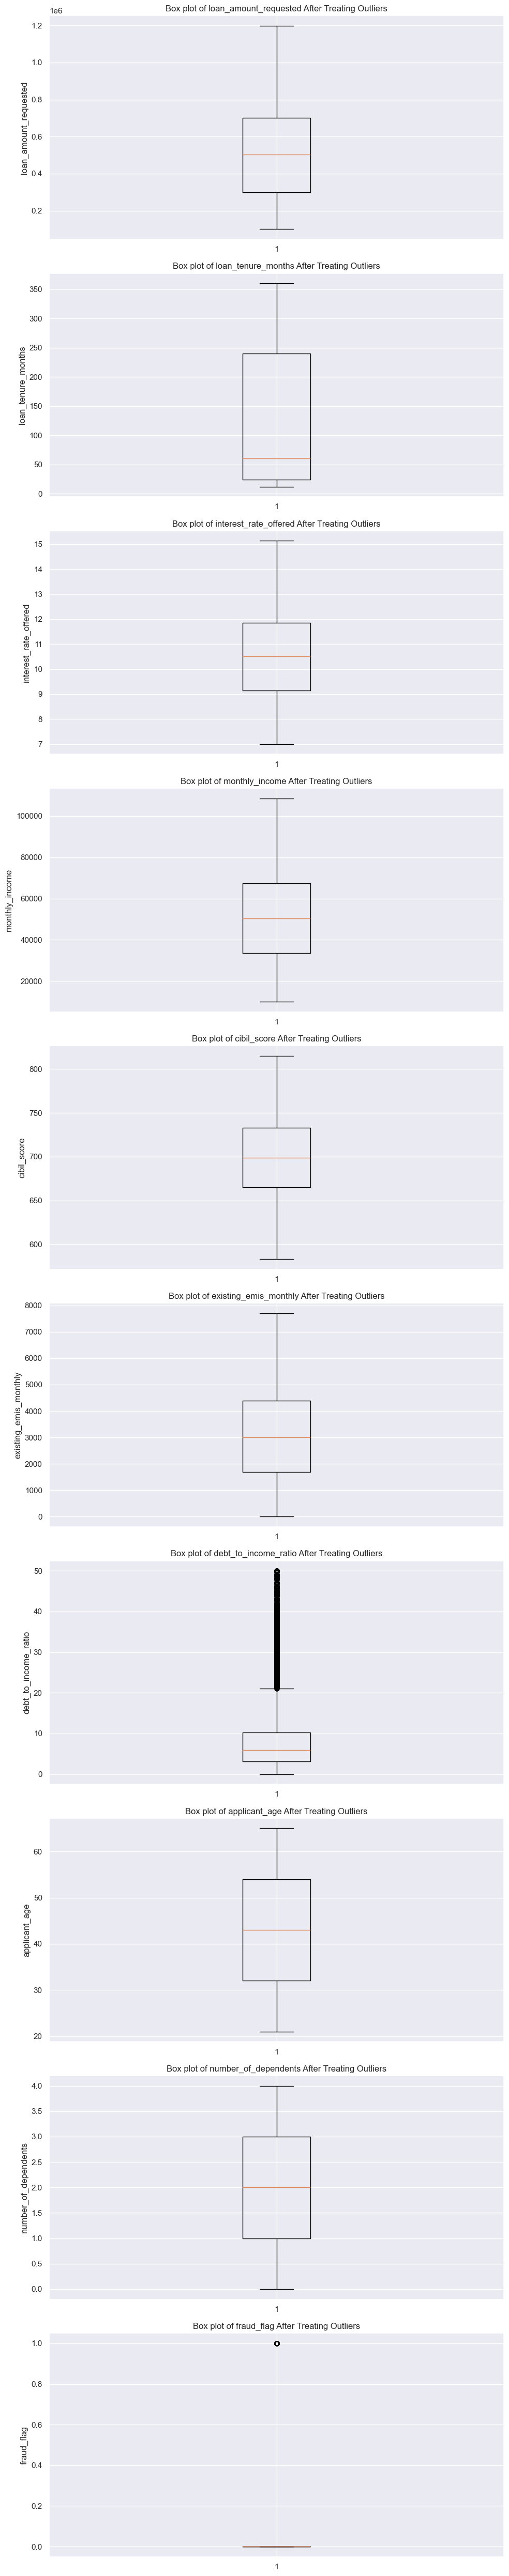

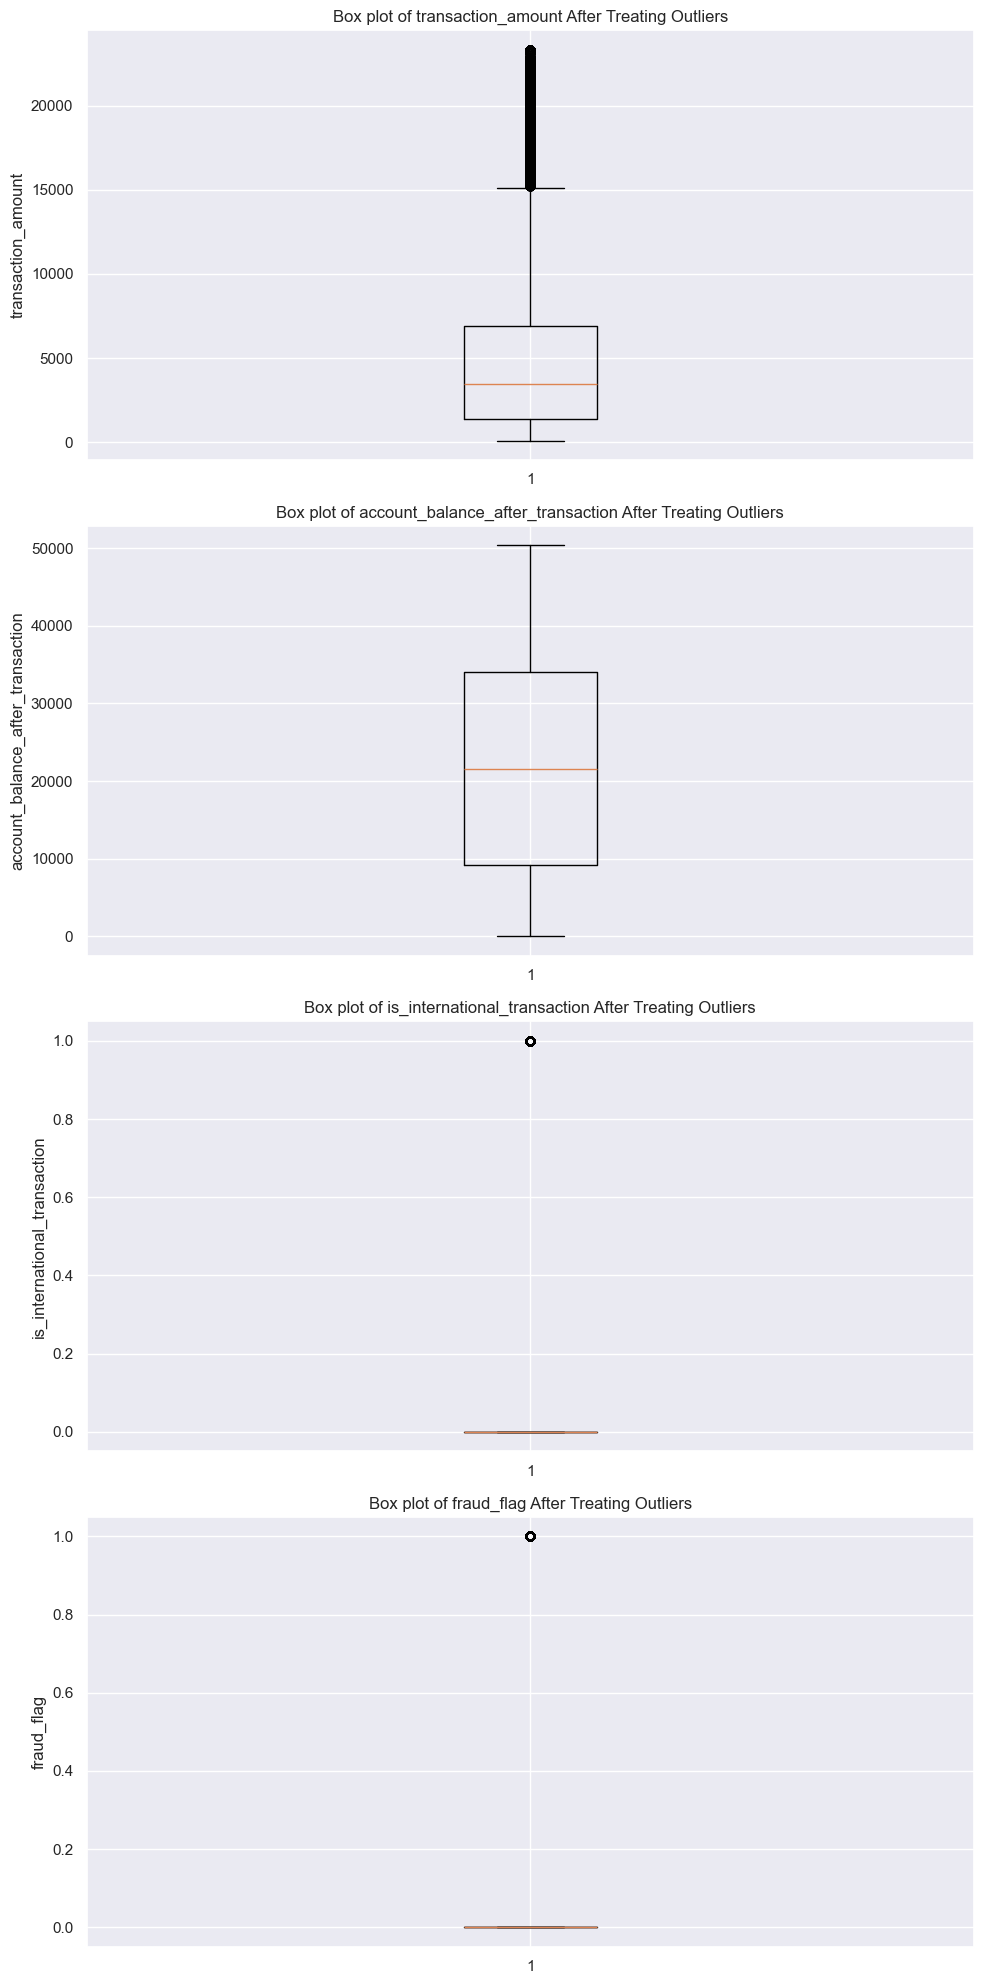

In [7]:

numerical_columns_loans = loan_applications_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_columns_transactions = transactions_df.select_dtypes(include=['float64', 'int64']).columns.tolist()

print("Box plots for numerical features after treating outliers:")


for col in numerical_columns_loans:
    lower_bound = loan_applications_df[col].quantile(0.01)
    upper_bound = loan_applications_df[col].quantile(0.99)
    loan_applications_df[col] = loan_applications_df[col].clip(lower=lower_bound, upper=upper_bound)


fig, axes = plt.subplots(nrows=len(numerical_columns_loans), figsize=(10, 5 * len(numerical_columns_loans)))
for i,col in enumerate(numerical_columns_loans):
    axes[i].boxplot(loan_applications_df[col].dropna())
    axes[i].set_title(f'Box plot of {col} After Treating Outliers')
    axes[i ].set_ylabel(col)
plt.tight_layout()
plt.show()

for col in numerical_columns_transactions:
    lower_bound = transactions_df[col].quantile(0.01)
    upper_bound = transactions_df[col].quantile(0.99)
    transactions_df[col] = transactions_df[col].clip(lower=lower_bound, upper=upper_bound)


fig, axes = plt.subplots(nrows=len(numerical_columns_transactions), figsize=(10, 5 * len(numerical_columns_transactions)))
for i, col in enumerate(numerical_columns_transactions):
    axes[i].boxplot(transactions_df[col].dropna())
    axes[i].set_title(f'Box plot of {col} After Treating Outliers')
    axes[i].set_ylabel(col)
plt.tight_layout()
plt.show()



#### 5.) Feature Engineering

In [8]:
epsilon = 1e-6

loan_applications_df['application_year'] = loan_applications_df['application_date'].dt.year
loan_applications_df['application_month'] = loan_applications_df['application_date'].dt.month
loan_applications_df['application_day_of_week'] = loan_applications_df['application_date'].dt.dayofweek
loan_applications_df['application_hour'] = loan_applications_df['application_date'].dt.hour
loan_applications_df['is_weekend'] = loan_applications_df['application_date'].dt.weekday > 4

In [9]:
loan_applications_df['loan_affordability_ratio'] = loan_applications_df['loan_amount_requested'] / (loan_applications_df['monthly_income'] + epsilon)
loan_applications_df['existing_emi_to_income_ratio'] = (
    loan_applications_df['existing_emis_monthly'] / (loan_applications_df['monthly_income'] + epsilon)
) * 100


In [10]:
time_windows = [30, 90, 180, 365]
aggregated_transaction_features = []

merged_df = pd.merge(
    loan_applications_df,
    transactions_df,
    on='customer_id',
    how='left'
)

merged_df = merged_df.sort_values(by=['customer_id', 'transaction_date'])

for customer_id, customer_group in merged_df.groupby('customer_id'):
    for _, loan_row in customer_group.drop_duplicates(subset='application_id').iterrows():
        application_date = loan_row['application_date']
        application_id = loan_row['application_id']

        transactions_before_application = customer_group[
            customer_group['transaction_date'] < application_date
        ].copy()

        app_features = {'application_id': application_id}

        for window_days in time_windows:
            window_start_date = application_date - timedelta(days=window_days)
            transactions_in_window = transactions_before_application[
                transactions_before_application['transaction_date'] >= window_start_date
            ]

            app_features[f'num_transactions_{window_days}d'] = transactions_in_window.shape[0]
            app_features[f'total_transaction_amount_{window_days}d'] = transactions_in_window['transaction_amount'].sum()
            app_features[f'average_transaction_amount_{window_days}d'] = transactions_in_window['transaction_amount'].mean() if transactions_in_window.shape[0] > 0 else 0
            app_features[f'unique_merchant_categories_{window_days}d'] = transactions_in_window['merchant_category'].nunique()

        aggregated_transaction_features.append(app_features)

transaction_aggregation_df = pd.DataFrame(aggregated_transaction_features)

In [11]:
aggregated_fraud_features = []

for customer_id, group in merged_df.groupby('customer_id'):
    for _, loan_row in group.drop_duplicates(subset='application_id').iterrows():
        application_date = loan_row['application_date']
        prior_transactions = group[group['transaction_date'] < application_date]

        fraud_metrics = {
            'application_id': loan_row['application_id'],
            'failed_transactions_count': (prior_transactions['transaction_status'] == 'Failed').sum(),
            'international_transactions_count': prior_transactions['is_international_transaction'].sum(),
        }

        aggregated_fraud_features.append(fraud_metrics)

fraud_features_df = pd.DataFrame(aggregated_fraud_features)

In [12]:
loan_applications_df = pd.merge(loan_applications_df, transaction_aggregation_df, on='application_id', how='left')
loan_applications_df = pd.merge(loan_applications_df, fraud_features_df, on='application_id', how='left')

In [23]:
loan_applications_df.columns.tolist()

['application_id',
 'customer_id',
 'application_date',
 'loan_type',
 'loan_amount_requested',
 'loan_tenure_months',
 'interest_rate_offered',
 'purpose_of_loan',
 'employment_status',
 'monthly_income',
 'cibil_score',
 'existing_emis_monthly',
 'debt_to_income_ratio',
 'property_ownership_status',
 'residential_address',
 'applicant_age',
 'gender',
 'number_of_dependents',
 'loan_status',
 'fraud_flag',
 'fraud_type',
 'application_year',
 'application_month',
 'application_day_of_week',
 'application_hour',
 'is_weekend',
 'loan_affordability_ratio',
 'existing_emi_to_income_ratio',
 'num_transactions_30d',
 'total_transaction_amount_30d',
 'average_transaction_amount_30d',
 'unique_merchant_categories_30d',
 'num_transactions_90d',
 'total_transaction_amount_90d',
 'average_transaction_amount_90d',
 'unique_merchant_categories_90d',
 'num_transactions_180d',
 'total_transaction_amount_180d',
 'average_transaction_amount_180d',
 'unique_merchant_categories_180d',
 'num_transactio

#### 6.) Feature Selection

In [ ]:
y = loan_applications_df['fraud_flag']
X = loan_applications_df.drop(columns=['fraud_flag', 'fraud_type','loan_status', 'application_id', 'customer_id', 'application_date'])

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ], remainder='passthrough'
)
x_processed = preprocessor.fit_transform(X)

##### 7.) Data Splitting

In [21]:

X_train, X_test, y_train, y_test = train_test_split(
    x_processed, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

#### 8.) Training the Model

In [26]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='saga'),
    "LightGBM Classifier": LGBMClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "XGBoost Classifier": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "CatBoost Classifier": CatBoostClassifier(verbose=0)
}

metrics_results = []

for i, (name, model) in enumerate(models.items()):
    print(list(models.keys())[i])
    
    model.fit(X_smote, y_smote)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    
    print('Model performance for Test set')
    print("- Precision: {:.4f}".format(report["weighted avg"]["precision"]))
    print("- Recall: {:.4f}".format(report["weighted avg"]["recall"]))
    print("- F1-Score: {:.4f}".format(report["weighted avg"]["f1-score"]))
    print("- ROC-AUC: {:.4f}".format(roc_auc))
    print('='*35)
    print('\n')
    
    metrics_results.append({
        "Model": name,
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-Score": report["weighted avg"]["f1-score"],
        "ROC-AUC": roc_auc
    })

Logistic Regression


c:\Users\Zuhayr Adams\anaconda3\envs\fraud_detection\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model performance for Test set
- Precision: 0.9806
- Recall: 0.9818
- F1-Score: 0.9811
- ROC-AUC: 0.7792


LightGBM Classifier
[LightGBM] [Info] Number of positive: 39179, number of negative: 39179
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37199
[LightGBM] [Info] Number of data points in the train set: 78358, number of used features: 396
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\Zuhayr Adams\anaconda3\envs\fraud_detection\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zuhayr Adams\anaconda3\envs\fraud_detection\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model performance for Test set
- Precision: 0.9899
- Recall: 0.9898
- F1-Score: 0.9881
- ROC-AUC: 0.9820


Random Forest Classifier
Model performance for Test set
- Precision: 0.9817
- Recall: 0.9814
- F1-Score: 0.9738
- ROC-AUC: 0.9593


Gradient Boosting Classifier
Model performance for Test set
- Precision: 0.9895
- Recall: 0.9894
- F1-Score: 0.9876
- ROC-AUC: 0.7959


XGBoost Classifier


c:\Users\Zuhayr Adams\anaconda3\envs\fraud_detection\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:55:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model performance for Test set
- Precision: 0.9902
- Recall: 0.9901
- F1-Score: 0.9885
- ROC-AUC: 0.8808


K-Nearest Neighbors
Model performance for Test set
- Precision: 0.9712
- Recall: 0.7734
- F1-Score: 0.8546
- ROC-AUC: 0.7460


Decision Tree Classifier
Model performance for Test set
- Precision: 0.9963
- Recall: 0.9963
- F1-Score: 0.9961
- ROC-AUC: 0.9098


CatBoost Classifier
Model performance for Test set
- Precision: 0.9948
- Recall: 0.9948
- F1-Score: 0.9944
- ROC-AUC: 0.9848




#### 9.) Evaluate the model

In [27]:
metrics_df = pd.DataFrame(metrics_results).sort_values(by="ROC-AUC", ascending=False)
print("\nModel Evaluation Results:")
print(metrics_df)


Model Evaluation Results:
                          Model  Precision  Recall  F1-Score   ROC-AUC
7           CatBoost Classifier   0.994827  0.9948  0.994429  0.984831
1           LightGBM Classifier   0.989905  0.9898  0.988137  0.981978
2      Random Forest Classifier   0.981747  0.9814  0.973765  0.959342
6      Decision Tree Classifier   0.996314  0.9963  0.996120  0.909756
4            XGBoost Classifier   0.990199  0.9901  0.988549  0.880848
3  Gradient Boosting Classifier   0.989513  0.9894  0.987580  0.795912
0           Logistic Regression   0.980612  0.9818  0.981146  0.779236
5           K-Nearest Neighbors   0.971214  0.7734  0.854590  0.746014


c:\Users\Zuhayr Adams\anaconda3\envs\fraud_detection\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


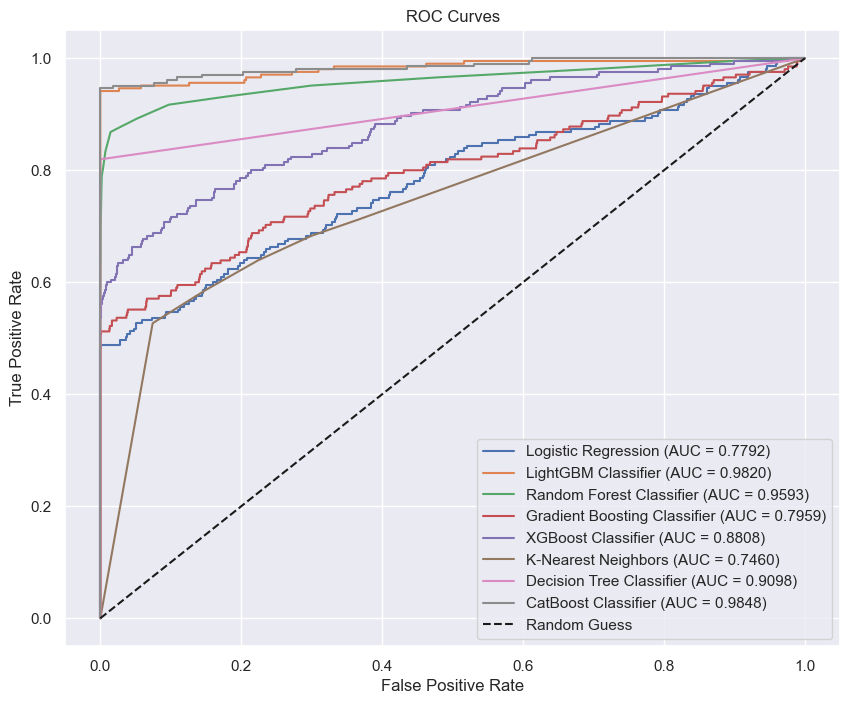

In [28]:
plt.figure(figsize=(10, 8))
for name, model in models.items():
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_pred_prob):.4f})")

plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()